## QUBO Warm‑Start for the Battery MILP (24‑qubit discharge‑timing skeleton)
_A detailed tutorial on constructing a quadratic unconstrainded binary optimization (QUBO) suitable for QAOA that produces an initial battery discharge schedule._

### Goal
The full battery optimization problem (joint operation of wind + battery) is mixed‑integer and nonlinear, mainly because:
- You must decide when to charge or discharge.
- SOC evolves deterministically.
- Power and energy constraints couple decisions across time.
- There are cycle and operational limits.

Solving the full MILP from a cold start may be slow or get stuck in poor branches.
A quantum warm-start uses QAOA to suggest a binary discharge timing skeleton, after which the classical solver fills in:
- exact charge/discharge magnitudes $c_t$,$d_t$​
- SOC trajectory $E_t$
- feasibility under limits
- best revenue

To keep the quantum circuit small and NISQ‑friendly, we isolate only the 24 binary timing decisions, one per hour.

We want a small QUBO (≤ 24 binary variables) that provides an initial guess for the discharge profile $d_t$, which can then be refined by a classical LP/MILP that enforces SOC dynamics and all engineering constraints.

Because of the no netting rule, the wind-scenario revenue term is constant w.r.t. battery decisions, so the battery schedule is driven by prices $p_t$ (and battery constraints). The QUBO therefore uses only $p_t$.

---

## Step 1 — Skeleton decision variables (24 qubits)

Define one binary variable per hour: $x_t \in \{0,1\}$ for $t=1,\dots,24$.

Interpretation:
- $x_t=1$ means “discharge during hour $t$”
- $x_t=0$ means “do not discharge during hour $t$”

To keep the QUBO minimal, we use a coarse discharge magnitude:
$\tilde d_t := 4x_t$ (MWh).

This yields a binary timing skeleton for discharge, which is the warm-start signal we want.

---

## Step 2 — Revenue term in QUBO form

Battery discharge revenue under the skeleton approximation is:
$\sum_{t=1}^{24} p_t \tilde d_t = \sum_{t=1}^{24} 4p_t x_t$.

A QUBO is typically a minimization, so we minimize negative revenue:
$E_{\mathrm{rev}}(x) := -\sum_{t=1}^{24} 4p_t x_t$.

---

## Step 3 — Continuity via a switching penalty

To discourage fragmented on/off behavior, add a quadratic penalty on switches:
$E_{\mathrm{sw}}(x) := \gamma \sum_{t=2}^{24} (x_t-x_{t-1})^2$, with $\gamma\ge 0$.

For binary variables, $x_t^2=x_t$, hence:
$(x_t-x_{t-1})^2 = x_t + x_{t-1} - 2x_tx_{t-1}$.

Interpretation:
- $\gamma$ acts like a cost per switch (up to scaling)
- larger $\gamma$ encourages fewer discharge blocks

---

## Step 4 — Cycle proxy as a cardinality penalty (no extra qubits)

The MILP cycle proxy is:
$\sum_{t=1}^{24} d_t \le 32$ MWh.

Under $\tilde d_t=4x_t$, this becomes:
$4\sum_{t=1}^{24} x_t \le 32$, i.e. $\sum_{t=1}^{24} x_t \le 8$.

With only 24 qubits, a standard way to enforce this without slack bits is a target-cardinality penalty:
$E_{\mathrm{card}}(x) := A\left(\sum_{t=1}^{24} x_t - K\right)^2$, with $A>0$ and $K=8$.

Notes:
- This enforces $\sum_t x_t \approx K$ (typically $\sum_t x_t = K$ if $A$ is large).
- This is a modification of the original inequality, acceptable for warm-starting because the classical refinement step will enforce SOC physics and may reshape discharges.

---

## Step 5 — Final QUBO objective

The final QUBO is:
$\min_{x\in\{0,1\}^{24}} E(x)$

with:
$E(x)=E_{\mathrm{rev}}(x)+E_{\mathrm{sw}}(x)+E_{\mathrm{card}}(x)$

i.e.:
$E(x)=-\sum_{t=1}^{24}4p_t x_t + \gamma\sum_{t=2}^{24}(x_t-x_{t-1})^2 + A\left(\sum_{t=1}^{24}x_t-K\right)^2$.

This uses exactly 24 binary variables.

---

## Step 6 — QUBO matrix form $x^\top Q x$

Write $x=(x_1,\dots,x_{24})^\top$. A QUBO can be written as:
$E(x)=x^\top Q x$,

using the convention:
$x^\top Q x = \sum_t Q_{tt}x_t + \sum_{i<j} Q_{ij}x_ix_j$.

### Diagonal terms (linear coefficients)

Define:
$\deg(t)=1$ for $t\in\{1,24\}$, and $\deg(t)=2$ for $t\in\{2,\dots,23\}$.

Then:
$Q_{tt} = -4p_t + \gamma\,\deg(t) + A(1-2K)$.

### Off-diagonal terms (quadratic couplers)

Cardinality penalty contributes for all $i<j$:
$Q_{ij} \mathrel{+}= 2A$.

Switching penalty contributes for adjacent hours:
$Q_{t-1,t} \mathrel{+}= -2\gamma$ for $t=2,\dots,24$.

Equivalently:
- if $|i-j|=1$, then $Q_{ij}=2A-2\gamma$
- if $|i-j|>1$, then $Q_{ij}=2A$

(Additive constants such as $AK^2$ can be dropped since they do not affect the minimizer.)


We have included the functions that generate the QUBO matrix in the class of the file `QAOA_guess_solver.py`, and we store the QUBO matrix in `../data/qubo_matrix_symmetric.csv`.

In [10]:
import sys
from pathlib import Path

def get_project_root():
    for path in (Path.cwd(), *Path.cwd().parents):
        if (path / 'src').exists():
            return path
    raise ModuleNotFoundError("Could not find 'src' directory from current working directory.")

project_root = get_project_root()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.plot_data_utils import PlotDataUtils
# Initialise utilities for the input CSV data
data_utils = PlotDataUtils(Path('../data/input_data.csv'))

# Then load the data
df = data_utils.load_data()

## Step 7 - QAOA with a QUBO 

Let us briefly lay out the strategy to convert the QUBO into a QAOA.

1. **QUBO → Cost Hamiltonian**  
   Convert the QUBO matrix \(Q\) into a diagonal Hamiltonian  
   $
   H_C = \sum_{i,j} Q_{ij} Z_i Z_j + \sum_i Q_{ii} Z_i
   $
   so each bitstring’s energy equals its QUBO cost.

2. **Initialize**  
   Start in the uniform superposition $ |+\rangle^{\otimes n} $.

3. **Alternate Unitaries (p layers)**  
   - **Cost step:** $ e^{-i \gamma_k H_C} $ (adds cost-dependent phases)  
   - **Mixer step:** $ e^{-i \beta_k \sum_i X_i} $ (moves probability between bitstrings)

4. **Optimize Angles**  
   Classically tune $ \{\gamma_k, \beta_k\} $ to minimize  
   $ \langle H_C \rangle $.

5. **Measure**  
   Sample the circuit; the most frequent bitstrings are near-optimal QUBO solutions.

base_primitive._run:WARNING:2025-12-14 11:22:45,185: Even though a session/batch context manager is open this job will run in job mode because the sampler primitive was initialized outside the context manager. Move the sampler initialization inside the context manager to run in a session/batch.



   Normal return from subroutine COBYLA

   NFVALS =   27   F =-3.917492E+03    MAXCV = 0.000000E+00
   X = 1.119389E+00   1.504985E+00
Best bitstring: 000010011000010010110111
Coarse discharge schedule (MWh): [0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 4.0, 0.0, 4.0, 4.0, 0.0, 4.0, 4.0, 4.0]


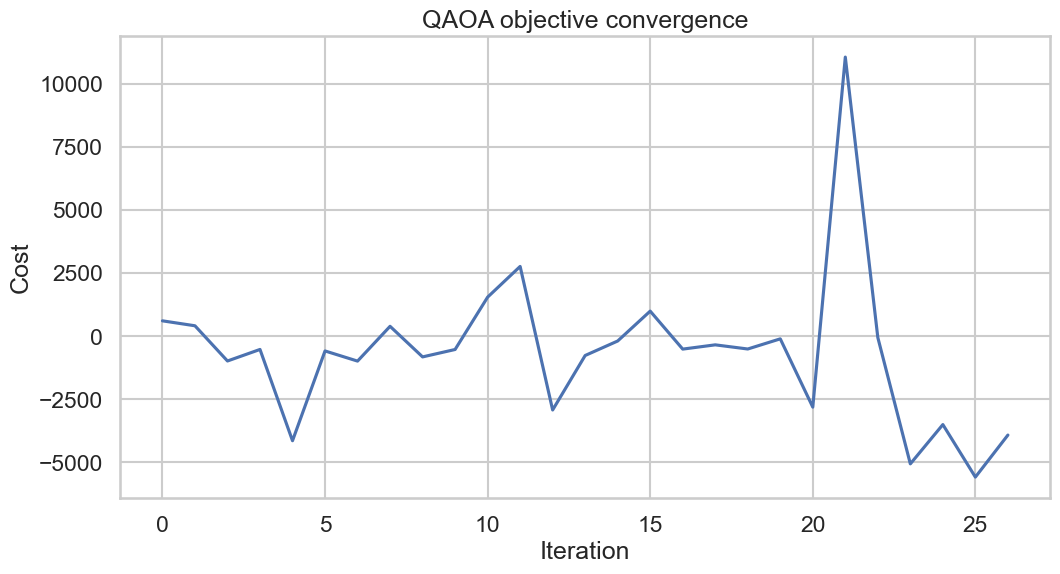

In [11]:
from qiskit_aer import AerSimulator
from src.qaoa_guess_solver import QAOAGuessSolver

# Example: loading a QUBO matrix from CSV (matches your original tutorial)
csv_path = "../data/qubo_matrix_symmetric.csv"

# Instantiate the solver; reps=1 corresponds to a single layer QAOA ansatz
solver = QAOAGuessSolver(reps=1)

# Solve the QUBO using the fake Sherbrooke device for the Estimator/Sampler
result = solver.solve(qubo_matrix_path=csv_path, backend=AerSimulator(),shots = 100_000,maxiter=40)

# Extract results
bitstring = result["bitstring"]
distribution = result["distribution"]
discharge_guess = result["discharge_guess"]
objective_values = result["objective_values"]
ansatz_circuit = result["circuit"]
operator = result["operator"]

print("Best bitstring:", bitstring)
print("Coarse discharge schedule (MWh):", discharge_guess)

# Optionally plot the optimisation progress
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(objective_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("QAOA objective convergence")
plt.show()


# IQM Resonance
Below, we are running the same QAOA circuit on IQM´s quantum computer "Emerald"

In [12]:
import qiskit 
from iqm.qiskit_iqm import IQMProvider
provider = IQMProvider("https://resonance.meetiqm.com/", quantum_computer="emerald",
            token=input("fiR7aNuq/88hFD4bMCImJ1JAf9MPI7ycYX9eNkjZhC4BmxwfQt91QIBQH7L6foF/"))
backend_hardware = provider.get_backend()

In [13]:
qc_transpiled = qiskit.transpile(
  ansatz_circuit,            
  layout_method='sabre',
  backend=backend_hardware,
  optimization_level=3,
)
  

And now we minimize using scipy´s minimize function:

In [14]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.optimize import minimize

from qiskit_aer import AerSimulator
backend_aer = AerSimulator()

In [15]:


def cost_fun_estimator(params, ansatz, hamiltonian, estimator):
    # we map the hamiltonian to the device
    isa_hamiltonian = hamiltonian.apply_layout(layout=ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)

    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)

    return cost


init_gamma = 0.05
init_beta = 0.01
init_params = [init_gamma, init_beta]*ansatz_circuit.reps
objective_func_vals = [] 
with Session(backend=backend_hardware) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 20_000

    result = minimize(cost_fun_estimator,
                        x0=init_params,
                        args=(qc_transpiled, operator, estimator),
                        method='COBYLA',
                        options={'maxiter':20, 'disp':True}
                         )
print(result)
                      


/Users/yanislefur/Documents/IQM_Hackathon/venv/lib/python3.11/site-packages/iqm/qiskit_iqm/iqm_provider.py:191: UserWarning: Unknown backend option(s): {'seed_simulator': None}
  warnings.warn(f"Unknown backend option(s): {unknown_options}")
Progress in queue:   0%|          | 0/1 [00:14<?, ?it/s]


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -14208.64709
       x: [ 5.342e-02  1.188e-02]
    nfev: 20
   maxcv: 0.0
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   20   F =-1.420865E+04    MAXCV = 0.000000E+00
   X = 5.342442E-02   1.187940E-02



A small plot following the trace of the optimisation

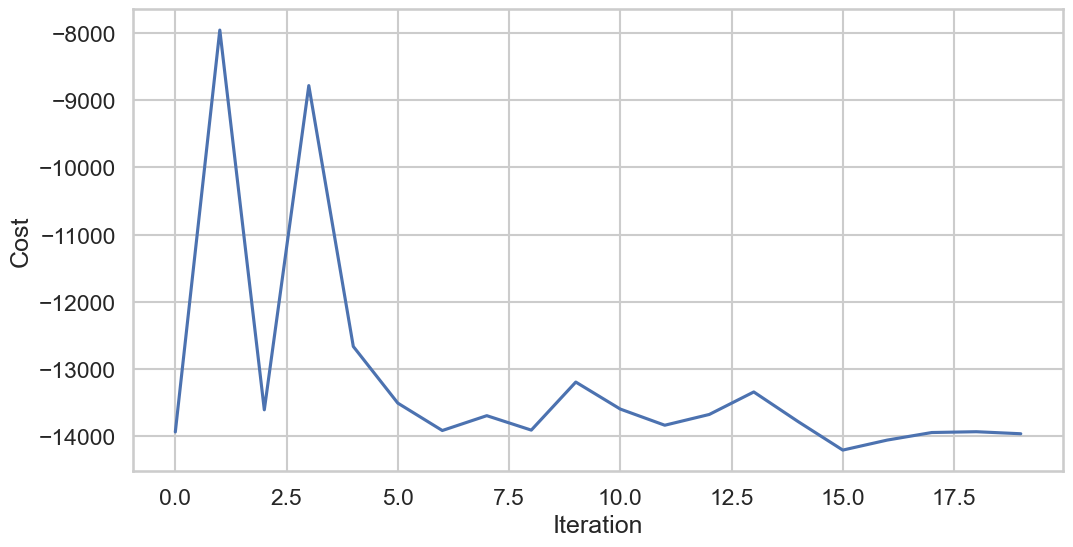

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [19]:
optimized_circuit = qc_transpiled.assign_parameters(result.x)

sampler = Sampler(mode=backend_aer)
sampler.options.default_shots = 1_000_000

pub = (optimized_circuit,)
job = sampler.run([pub])
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}


And below we see the histogram where the QAOA is supposed to highlight the solution with more probability.
Note that we can only sample the circuit 20,000 times while the bit string has $2^{24}=16.777.216$ possible states, and hence the circuit would require sampling both through repetition and individual shots of a similar magnitude in post-processing.

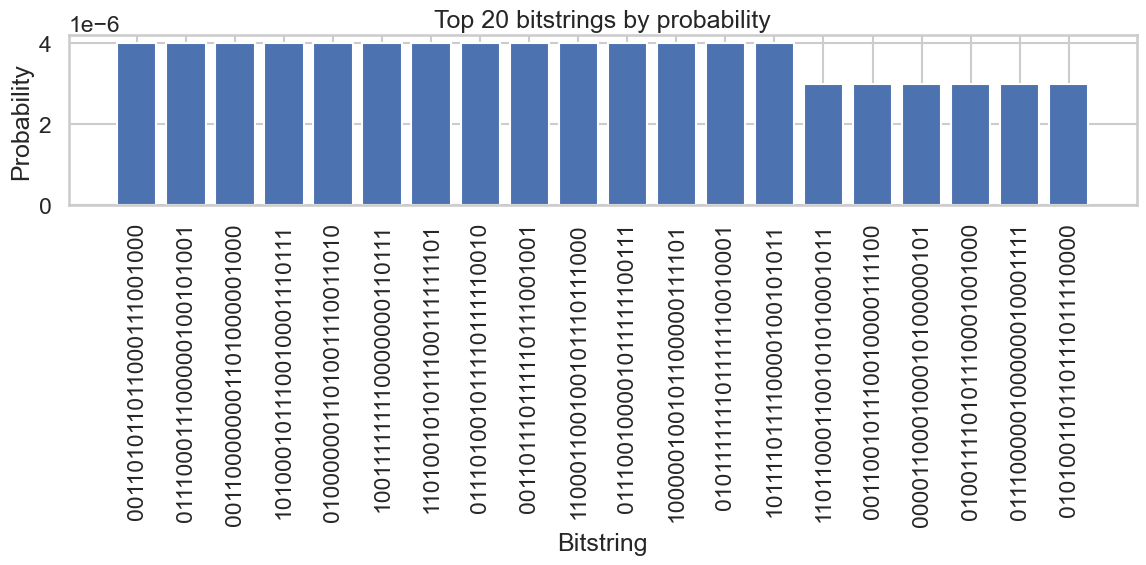

In [ ]:
# plot top 20 bitstrings by probability  
top_k = 20
items = sorted(final_distribution_int.items(), key=lambda kv: kv[1], reverse=True)[:min(top_k, len(final_distribution_int))]
if not items:
    print("No distribution to plot.")
else:
    ints, probs = zip(*items)
    bins = [format(k, f'0{24}b') for k in ints]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(bins)), probs)
    plt.xticks(range(len(bins)), bins, rotation=90)
    plt.xlabel("Bitstring")
    plt.ylabel("Probability")
    plt.title(f"Top {len(bins)} bitstrings by probability")
    plt.tight_layout()
    plt.show()